In [20]:
import pandas as pd 
import numpy as np

import seaborn as sns
sns.set(style="whitegrid")

from imblearn.over_sampling import SMOTE

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn import metrics

import matplotlib.pyplot as plt

In [39]:
#Reading the csv file of dataset and weight matrix
df_numeric = pd.read_csv('data_numeric_norm.csv')
df_target=pd.read_csv('data_target.csv')

In [40]:
#Make df_numeric to DataFrame
df_numeric=pd.DataFrame(df_numeric)

In [41]:
df_numeric.head(3)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.053024,0.059323,0.059323,0.002864,0.004472,0.0,0.433333,0.277778,0.016166,0.016166,...,0.0,0.0,0.434783,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.031252,0.037665,0.037665,0.000958,0.001497,0.0,0.214286,0.222222,0.014591,0.014591,...,1.0,0.0,0.130435,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.014897,0.016667,0.016667,0.051634,0.080646,0.0,0.704762,0.055556,0.030051,0.030051,...,0.0,0.0,0.173913,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [42]:
#Using SMOTE method to balance clases of dataset
y = df_target['TARGET'].astype('int')
X_balance,Y_balance = SMOTE().fit_sample(df_numeric,y)
X_balance = pd.DataFrame(X_balance, columns = df_numeric.columns)

In [43]:
X=X_balance.values
y=Y_balance.values

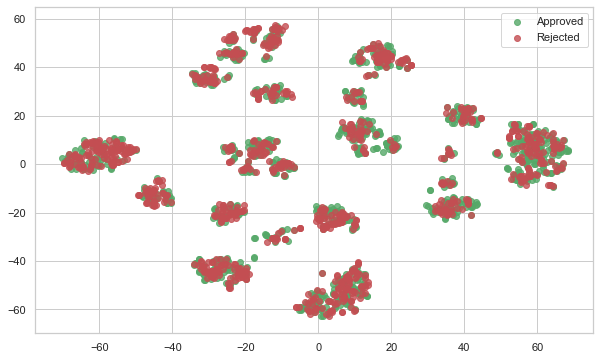

In [44]:
#Make the representation into 2 dimensions and then plot all points
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=1)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Approved')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Rejected')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, y, "original.png")

In [45]:
#Input layer 
input_layer = Input(shape=(X.shape[1],))

#Encoding layers
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-3))(input_layer)
encoded = Dense(50, activation='tanh')(encoded)

#Decoding layers
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

#Output layer
output_layer = Dense(X.shape[1], activation='sigmoid')(decoded)

In [46]:
#Build the model and optimize it
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="Adam", loss="mse")

In [47]:
#Seperate rejected and approved applicants
x_approved, x_reject = X[y == 0], X[y == 1]

In [48]:
#Fit the model on 500 approved applicants
autoencoder.fit(x_approved[0:500], x_approved[0:500], 
                batch_size = 310, epochs = 10, 
                shuffle = True, validation_split = 0.7);

Train on 150 samples, validate on 350 samples
Epoch 1/10
150/150 [==============================] - 0s 2ms/step - loss: 31.3546 - val_loss: 57.7139
Epoch 2/10
150/150 [==============================] - 0s 133us/step - loss: 30.6277 - val_loss: 56.4179
Epoch 3/10
150/150 [==============================] - 0s 112us/step - loss: 29.9261 - val_loss: 55.1706
Epoch 4/10
150/150 [==============================] - 0s 132us/step - loss: 29.2469 - val_loss: 53.9724
Epoch 5/10
150/150 [==============================] - 0s 131us/step - loss: 28.5961 - val_loss: 52.8273
Epoch 6/10
150/150 [==============================] - 0s 137us/step - loss: 27.9719 - val_loss: 51.7315
Epoch 7/10
150/150 [==============================] - 0s 114us/step - loss: 27.3767 - val_loss: 50.6880
Epoch 8/10
150/150 [==============================] - 0s 111us/step - loss: 26.8097 - val_loss: 49.6965
Epoch 9/10
150/150 [==============================] - 0s 146us/step - loss: 26.2688 - val_loss: 48.7532
Epoch 10/10
150/150 

# Obtain the Latent Representations

In [49]:
#Obtain the latent representation that is happened in third layer
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [50]:
#Predict on all dataset
norm_hid_rep = hidden_representation.predict(x_approved)
fraud_hid_rep = hidden_representation.predict(x_reject)

# Visualize The Latend Representation

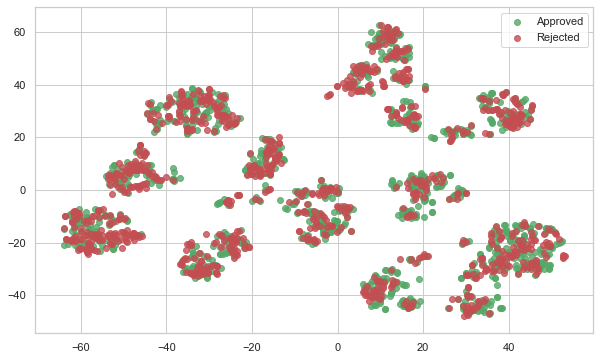

In [51]:
#Visualise the latent representation
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")


# Apply Linear Classification and Find Accuracy

In [52]:
#Evaluate logistic regression 
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.60      0.55      0.57       248
         1.0       0.59      0.63      0.61       252

    accuracy                           0.59       500
   macro avg       0.59      0.59      0.59       500
weighted avg       0.59      0.59      0.59       500

Accuracy Score:  0.592


In [53]:
#Find AUC
test_predictions = pred_y
test_predictions_class = ((test_predictions > 0.5) * 1).flatten()
test_df = pd.DataFrame(
    {
        "Predicted_score": test_predictions.flatten(),
        "Predicted_class": test_predictions_class,
        "True": val_y,
    }
)
roc_auc = metrics.roc_auc_score(val_y, pred_y)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.5916538658474142


In [54]:
#Calculate f1 score
f1_score(val_y, pred_y, average='macro')

0.5910577971646673

In [55]:
#Recall
from sklearn.metrics import recall_score
recall_score(val_y, pred_y, average='macro')

0.5916538658474142

In [56]:
#Precision
from sklearn.metrics import precision_score
precision_score(val_y, pred_y, average='macro')

0.5923632610939112